Assignment 2: Prediction and Classification

# Introduction
Problem 1 is optional - for extra credit!
Problems 2 and 3 will be graded for the Lab 2.  


In this assignment you will be using regression and classification to explore different data sets.  

**First**: You will use data from before 2002 in the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics) to create a metric for picking baseball players using linear regression.  This database contains the "complete batting and pitching statistics from 1871 to 2013, plus fielding statistics, standings, team stats, managerial records, post-season data, and more". [Documentation provided here](http://seanlahman.com/files/database/readme2012.txt).

**Second**: You will use the famous [iris](http://en.wikipedia.org/wiki/Iris_flower_data_set) data set to perform a $k$-neareast neighbor classification using cross validation.  While it was introduced in 1936, it is still [one of the most popular](http://archive.ics.uci.edu/ml/) example data sets in the machine learning community. Wikipedia describes the data set as follows: "The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres." Here is an illustration what the four features measure:

!["iris data features"](http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png)
http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png

**Third**: You will investigate the influence of higher dimensional spaces on the classification using another standard data set in machine learning called the The [digits data set](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).   Each digit is represented by an 8x8 pixel image patch. In addition, the gray values are restricted to 16 different values (4 bit). 



## Load Python modules

In [1]:
# prepare the notebook for matplotlib
%matplotlib inline 

import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import seaborn as sns 
import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics

# Problem 1: Sabermetrics

Using data preceding the 2002 season pick 10 offensive players keeping the payroll under $20 million (assign each player the median salary). Predict how many games this team would win in a 162 game season.  

In this problem we will be returning to the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics).  From this database, we will be extract five data sets containing information such as yearly stats and standing, batting statistics, fielding statistics, player names, player salaries and biographical information. You will explore the data in this database from before 2002 and create a metric for picking players. 

#### Problem 1(a) 

Load in [these CSV files](http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip) from the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics). For this assignment, we will use the 'Teams.csv', 'Batting.csv', 'Salaries.csv', 'Fielding.csv', 'Master.csv' tables. Read these tables into separate pandas DataFrames with the following names. 

CSV file name | Name of pandas DataFrame
:---: | :---: 
Teams.csv | teams
Batting.csv | players
Salaries.csv | salaries
Fielding.csv | fielding
Master.csv | master

In [2]:
### Your code here ###
teams = pd.read_csv('data/baseball_data/teams.csv')
players = pd.read_csv('data/baseball_data/Batting.csv')
salaries = pd.read_csv('data/baseball_data/Salaries.csv')
fielding = pd.read_csv('data/baseball_data/Fielding.csv')
master = pd.read_csv('data/baseball_data/Master.csv', index_col=0)
master.index.name = None

#### Problem 1(b)

Calculate the median salary for each player and create a pandas DataFrame called `medianSalaries` with four columns: (1) the player ID, (2) the first name of the player, (3) the last name of the player and (4) the median salary of the player. Show the head of the `medianSalaries` DataFrame.   

In [3]:
first_last = master[['nameFirst', 'nameLast']]
yearID_salary = salaries[['salary', 'playerID']]

In [4]:
# put the playerID values into the index. This is for merging later
yearID_salary.index = yearID_salary['playerID'].values

In [5]:
salary_first_last = pd.merge(left = yearID_salary, right = first_last,left_index=True, right_index=True, how = "inner")

In [6]:
medianSalaries = salary_first_last.groupby(['nameFirst', 'nameLast', 'playerID'])['salary'].median().reset_index()
medianSalaries.head()

,nameFirst,nameLast,playerID,salary
0,A. J.,Burnett,burneaj01,3650000
1,A. J.,Ellis,ellisaj01,490000
2,A. J.,Griffin,griffaj01,492500
3,A. J.,Hinch,hinchaj01,245000
4,A. J.,Pierzynski,pierzaj01,4000000


#### Problem 1(c)

Now, consider only team/season combinations in which the teams played 162 Games. Exclude all data from before 1947. Compute the per plate appearance rates for singles, doubles, triples, HR, and BB. Create a new pandas DataFrame called `stats` that has the teamID, yearID, wins and these rates.

**Hint**: Singles are hits that are not doubles, triples, nor HR. Plate appearances are base on balls plus at bats.

PA = AB + BB

In [7]:
year_condition = teams['yearID'] >= 1947
games_condition = teams['G'] >= 162

In [8]:
filtered_teams = teams[year_condition & games_condition]

In [9]:
PA = pd.Series(filtered_teams['AB']) + pd.Series(filtered_teams['BB'])

In [10]:
Singles = (pd.Series(filtered_teams['H']) - pd.Series(filtered_teams['2B']) - pd.Series(filtered_teams['3B']) - pd.Series(filtered_teams['HR']))/PA
pa_singles = {'PA': PA, '1B':Singles}

# updating dictionary, inside update is dictionary comprehension of everything divided by PA
pa_singles.update({column:pd.Series(filtered_teams[column]) / PA for column in ['2B', '3B', 'HR', 'BB']})
stats = pd.concat([filtered_teams[['teamID', 'yearID', 'W']], pd.DataFrame(data = pa_singles)], axis = 1)

In [11]:
stats.head()

,teamID,yearID,W,1B,2B,3B,BB,HR,PA
1359,NYA,1961,109,0.161750,0.031793,0.006555,0.088987,0.039331,6102
1360,DET,1961,101,0.165704,0.034488,0.008502,0.107956,0.028874,6234
1361,BAL,1961,95,0.161828,0.037446,0.005939,0.095843,0.024579,6062
1362,CHA,1961,86,0.176056,0.035375,0.007534,0.090075,0.022601,6106
1364,BOS,1961,76,0.162632,0.040780,0.006011,0.105118,0.018197,6155


#### Problem 1(d)

<b>Question: </b>Is there a noticeable time trend in the rates computed in Problem 1(c)? <br>
There are seems to be an increasing number of 2B and HR as the years go by. There is also missing data in the graphs from the 1994–95 Major League Baseball strike. These trends are graphed below (HR, BB, 1B, 2B, 3B). 

In [12]:
yearTrends = stats.groupby('yearID').mean().reset_index()

try:
    yearTrends.drop(['PA', 'W'], axis=1, inplace=True)
except: 
    pass
yearTrends.head()

,yearID,1B,2B,3B,BB,HR
0,1961,0.162924,0.035939,0.006568,0.099449,0.025648
1,1962,0.168355,0.035621,0.006772,0.089365,0.024662
2,1963,0.163161,0.033769,0.006798,0.080538,0.021204
3,1964,0.165559,0.035530,0.006330,0.080035,0.022923
4,1965,0.160910,0.035027,0.006557,0.083755,0.022416


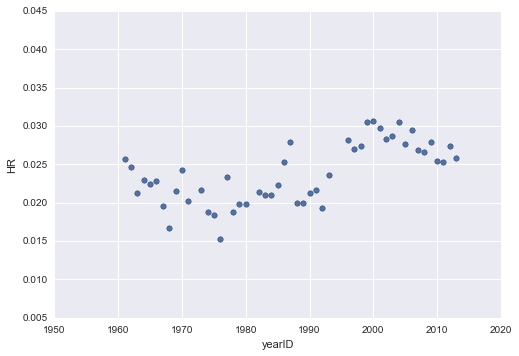

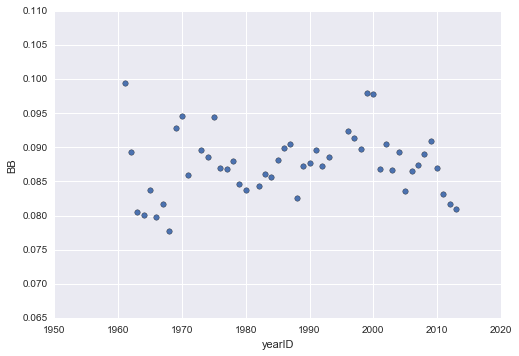

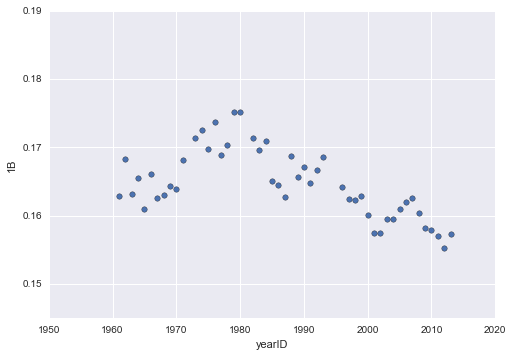

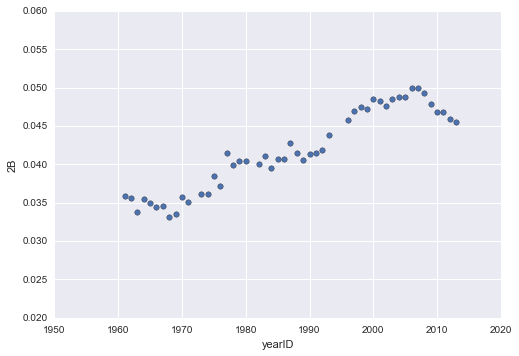

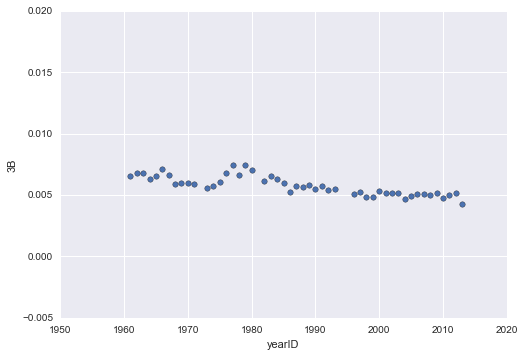

In [13]:
for base in ['HR', 'BB', '1B', '2B', '3B']:
    yearTrends.plot(kind='scatter', x = 'yearID', y = base, s = 30);

#### Problem 1(e) 

Using the `stats` DataFrame from Problem 1(c), adjust the singles per PA rates so that the average across teams for each year is 0. Do the same for the doubles, triples, HR, and BB rates. 

In [14]:
stats.index = stats.yearID.values

In [15]:
stats_mean = stats.groupby('yearID')[['1B', '2B', '3B', 'HR', 'BB']].mean()
stats_mean.index.name = None

In [16]:
stats = pd.concat([stats[['1B', '2B', '3B', 'BB', 'HR']] - stats_mean, stats[['teamID', 'yearID', 'W']] ], axis = 1)
stats.head()

,1B,2B,3B,BB,HR,teamID,yearID,W
1961,-0.001174,-0.004146,-0.000012,-0.010462,0.013684,NYA,1961,109
1961,0.002780,-0.001451,0.001934,0.008507,0.003226,DET,1961,101
1961,-0.001096,0.001507,-0.000629,-0.003606,-0.001068,BAL,1961,95
1961,0.013132,-0.000564,0.000966,-0.009374,-0.003047,CHA,1961,86
1961,-0.000292,0.004841,-0.000556,0.005668,-0.007451,BOS,1961,76


#### Problem 1(f)

Build a simple linear regression model to predict the number of wins from the average adjusted singles, double, triples, HR, and BB rates. To decide which of these terms to include fit the model to data from 2002 and compute the average squared residuals from predictions to years past 2002. Use the fitted model to define a new sabermetric summary: offensive predicted wins (OPW). Hint: the new summary should be a linear combination of one to five of the five rates.


In [17]:
import math
from math import isnan

def corr(list1, list2):
    '''Find correlation between 2 datasets. Removes NaNs'''
    #Remove Nan:
    new_list1, new_list2 = [], []
    for i1,i2 in zip(list1,list2):
        if (isnan(i1)==False) & (isnan(i2)==False):
            new_list1.append(float(i1))
            new_list2.append(float(i2))
    cov = np.cov([new_list1,new_list2])[0][1]
    std1 = np.std(new_list1)
    std2 = np.std(new_list2)
    corr = cov/(std1*std2)
    return corr

In [18]:
l1 = stats['W']
print 'Correlations vs Wins'
for head in ['HR','BB','3B','2B','1B']:
    l2 = stats[head]
    correlation = corr(l1,l2)
    print head, correlation

Correlations vs Wins
HR 0.356460366494
BB 0.353907579859
3B 0.0836098870427
2B 0.220768982251
1B 0.12391416583


In [19]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

train = stats[stats['yearID']<2002]
valid = stats[stats['yearID']>=2002]
x_train = train[['1B', '2B', '3B', 'BB', 'HR', 'W']];
x_test = valid[['1B', '2B', '3B', 'BB', 'HR', 'W']];
y_train = train['W']
y_test = valid['W']

In [20]:
hit_type = ['HR', 'BB', '2B', '1B', '3B']

In [21]:
for index in xrange(6):
    #print lama[0:index+1]
    lm = LinearRegression()
    if index == 0:
        lm.fit(x_train['HR'].reshape(762,1), y_train)
        print lm.coef_, lm.score(x_test['HR'].reshape(334,1), y_test)
        print("Residual sum of squares: %.2f" % np.mean((lm.predict(x_test['HR'].reshape(334,1)) - y_test) ** 2))
    else:   
        lm.fit(x_train[hit_type[0:index]], y_train)
        print lm.coef_, lm.score(x_test[hit_type[0:index]], y_test)
        print("Residual sum of squares: %.2f" % np.mean((lm.predict(x_test[hit_type[0:index]]) - y_test) ** 2))

[ 808.67753016] 0.144075352656
Residual sum of squares: 112.01
[ 808.67753016] 0.144075352656
Residual sum of squares: 112.01
[ 661.04694958  302.92859127] 0.235423404219
Residual sum of squares: 100.05
[ 582.53063644  335.68327466  639.32385273] 0.252102350139
Residual sum of squares: 97.87
[ 815.81907237  477.20191057  574.32614456  536.19943812] 0.365777146885
Residual sum of squares: 82.99
[  901.27995663   497.9811987    433.25242783   508.46196164  1290.8392896 ] 0.365913507791
Residual sum of squares: 82.98


In [22]:
opw_dict = {hit:pd.Series(stats[hit])*lm.coef_[index] for index, hit in enumerate(hit_type)}
opw_df = pd.DataFrame(data = {'OPW':pd.DataFrame(data = opw_dict).sum(axis = 1)})
pd.concat([stats, opw_df ], axis = 1).head(10)

,1B,2B,3B,BB,HR,teamID,yearID,W,OPW
1961,-0.001174,-0.004146,-0.000012,-0.010462,0.013684,NYA,1961,109,4.713727
1961,0.002780,-0.001451,0.001934,0.008507,0.003226,DET,1961,101,10.425825
1961,-0.001096,0.001507,-0.000629,-0.003606,-0.001068,BAL,1961,95,-3.475037
1961,0.013132,-0.000564,0.000966,-0.009374,-0.003047,CHA,1961,86,0.265575
1961,-0.000292,0.004841,-0.000556,0.005668,-0.007451,BOS,1961,76,-2.661951
1961,-0.015176,-0.000231,-0.002964,0.012098,0.005311,LAA,1961,70,-0.831386
1961,0.001827,0.000043,0.001262,-0.002831,-0.010655,KC1,1961,61,-8.436753
1962,-0.001207,0.002915,-0.002116,0.004405,0.007291,NYA,1962,96,6.682763
1962,-0.006358,-0.000999,-0.000492,0.015144,0.005129,MIN,1962,91,7.862983
1962,-0.008873,0.002406,-0.001035,0.009307,-0.002206,LAA,1962,86,-2.159578


#### Problem 1(g)

Now we will create a similar database for individual players. Consider only player/year combinations in which the player had at least 500 plate appearances. Consider only the years we considered for the calculations above (after 1947 and seasons with 162 games). For each player/year compute singles, doubles, triples, HR, BB per plate appearance rates. Create a new pandas DataFrame called `playerstats` that has the playerID, yearID and the rates of these stats.  Remove the average for each year as for these rates as done in Problem 1(e). 

In [23]:
year_cond = players['yearID'] >= 1947
game_cond = players['G'] >= 162
players = players[year_cond & game_cond]
players.index = players.yearID.values

In [24]:
PA = pd.Series(players['AB']) + pd.Series(players['BB'])
singles = (pd.Series(players['H']) - pd.Series(players['2B']) - pd.Series(players['3B']) - pd.Series(players['HR']))/PA

In [25]:
pa_singles = {'1B':singles, 'PA': PA}
# updating dictionary, inside update is dictionary comprehension of everything divided by PA
pa_singles.update({column:pd.Series(players[column]) / PA for column in ['2B', '3B', 'HR', 'BB']})
playerstats = pd.concat([players[['playerID', 'yearID']], pd.DataFrame(data = pa_singles)], axis = 1)
playerstats = playerstats[playerstats['PA'] >= 500]

In [26]:
play_stats_mean = playerstats.groupby('yearID')[['1B', '2B', '3B', 'HR', 'BB']].mean()
play_stats_mean.index.name = None
play_stats_mean['playerID'] = ' '
play_stats_mean['yearID'] = 0
playerstats = playerstats[['1B', '2B', '3B', 'BB', 'HR', 'playerID', 'yearID']] + -1*play_stats_mean

Show the head of the `playerstats` DataFrame. 

In [27]:
playerstats.head()

,1B,2B,3B,BB,HR,playerID,yearID
1961,-0.048011,0.007005,-0.006953,0.074385,0.041146,colavro01,1961
1961,0.033678,-0.011532,-0.002601,-0.044619,-0.019174,richabo01,1961
1961,0.015609,0.017048,-0.000036,-0.022237,-0.013719,robinbr01,1961
1961,-0.001277,-0.012520,0.009591,-0.007528,-0.008253,woodja01,1961
1962,0.007904,-0.001749,-0.006844,-0.031137,0.015932,cepedor01,1962


#### Problem 1(h)

Using the `playerstats` DataFrame created in Problem 1(g), create a new DataFrame called `playerLS` containing the player's lifetime stats. This DataFrame should contain the playerID, the year the player's career started, the year the player's career ended and the player's lifetime average for each of the quantities (singles, doubles, triples, HR, BB). For simplicity we will simply compute the average of the rates by year (a more correct way is to go back to the totals). 

In [28]:
careerAverage = playerstats.groupby('playerID')[['1B', '2B', '3B', 'HR', 'BB']].mean()
careerAverage.index.name = None

In [29]:
yearStart = playerstats[['playerID', 'yearID']].groupby('playerID').min()
yearEnd = playerstats[['playerID', 'yearID']].groupby('playerID').max()
yearStart.index.name = None
yearEnd.index.name = None
yearEnd.rename(columns={'yearID': 'Career Ended'}, inplace=True)
yearStart.rename(columns={'yearID': 'Career Start'}, inplace=True)
#yearEnd
playerLS = pd.concat([careerAverage,yearStart, yearEnd], axis=1)
playerLS['playerID'] = playerLS.index.values

Show the head of the `playerLS` DataFrame. 

In [30]:
# only including valid years that have over 500 plate appearances
playerLS.head()

,1B,2B,3B,HR,BB,Career Start,Career Ended,playerID
abreubo01,-0.022295,0.008226,-0.002379,-0.003980,0.054759,2001,2005,abreubo01
allendi01,-0.004268,0.015058,0.010584,0.012612,0.014706,1964,1964,allendi01
alomasa01,0.011155,-0.008823,-0.002639,-0.012807,-0.030193,1970,1971,alomasa01
alouma01,0.077250,0.015560,0.001520,-0.033637,-0.059120,1969,1969,alouma01
bagweje01,-0.026592,0.007757,-0.001099,0.012338,0.057971,1992,1999,bagweje01


#### Problem 1(i)

Compute the OPW for each player based on the average rates in the `playerLS` DataFrame. You can interpret this summary statistic as the predicted wins for a team with 9 batters exactly like the player in question. Add this column to the playerLS DataFrame. Call this colum OPW.

In [31]:
opw_hits = {hit:pd.Series(playerLS[hit])*lm.coef_[index] for index, hit in enumerate(hit_type)}
start_end = {}
start_end.update({'Career Start': pd.Series(playerLS['Career Start']), 'Career Ended': pd.Series(playerLS['Career Ended']), 'playerID': pd.Series(playerLS['playerID']) })
start_end_df = pd.DataFrame(data = start_end)
opw = pd.DataFrame(data = {'OPW':pd.DataFrame(data = opw_hits).sum(axis = 1)})
playerLS = pd.concat([start_end_df, opw, playerLS[['1B', '2B', '3B', 'HR', 'BB']] ], axis = 1)
playerLS.head()

,Career Ended,Career Start,playerID,OPW,1B,2B,3B,HR,BB
abreubo01,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.003980,0.054759
allendi01,1964,1964,allendi01,36.706075,-0.004268,0.015058,0.010584,0.012612,0.014706
alomasa01,1971,1970,alomasa01,-28.135106,0.011155,-0.008823,-0.002639,-0.012807,-0.030193
alouma01,1969,1969,alouma01,-11.774550,0.077250,0.015560,0.001520,-0.033637,-0.059120
bagweje01,1999,1992,bagweje01,28.409838,-0.026592,0.007757,-0.001099,0.012338,0.057971


#### Problem 1(j)

Add four columns to the `playerLS` DataFrame that contains the player's position (C, 1B, 2B, 3B, SS, LF, CF, RF, or OF), first name, last name and median salary. 

In [32]:
medianSalaries.head()

,nameFirst,nameLast,playerID,salary
0,A. J.,Burnett,burneaj01,3650000
1,A. J.,Ellis,ellisaj01,490000
2,A. J.,Griffin,griffaj01,492500
3,A. J.,Hinch,hinchaj01,245000
4,A. J.,Pierzynski,pierzaj01,4000000


In [33]:
playerLS.head()

,Career Ended,Career Start,playerID,OPW,1B,2B,3B,HR,BB
abreubo01,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.003980,0.054759
allendi01,1964,1964,allendi01,36.706075,-0.004268,0.015058,0.010584,0.012612,0.014706
alomasa01,1971,1970,alomasa01,-28.135106,0.011155,-0.008823,-0.002639,-0.012807,-0.030193
alouma01,1969,1969,alouma01,-11.774550,0.077250,0.015560,0.001520,-0.033637,-0.059120
bagweje01,1999,1992,bagweje01,28.409838,-0.026592,0.007757,-0.001099,0.012338,0.057971


In [34]:
playerLS = playerLS.merge(medianSalaries, how='inner', on='playerID')
playerID_Pos = fielding[['playerID','POS']]
playerLS = playerLS.merge(playerID_Pos, how='inner', on='playerID')

In [35]:
playerLS = playerLS.drop_duplicates() # delete multiples of same position with same player

Show the head of the `playerLS` DataFrame. 

In [36]:
playerLS.head()

,Career Ended,Career Start,playerID,OPW,1B,2B,3B,HR,BB,nameFirst,nameLast,salary,POS
0,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.00398,0.054759,Bobby,Abreu,9000000,LF
1,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.00398,0.054759,Bobby,Abreu,9000000,OF
2,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.00398,0.054759,Bobby,Abreu,9000000,RF
3,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.00398,0.054759,Bobby,Abreu,9000000,CF
9,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.00398,0.054759,Bobby,Abreu,9000000,DH


#### Problem 1(k)

Subset the `playerLS` DataFrame for players active in 2002 and 2003 and played at least three years. Plot and describe the relationship bewteen the median salary (in millions) and the predicted number of wins. 

In [37]:
playerLS.to_csv('playerSalary.csv')
!pwd

/Users/mgalarny/Documents/youtube/DSE220_Machine_Learning/IPynb


In [38]:
playerLS[['Career Start','Career Ended']] = playerLS[['Career Start','Career Ended']]

cond1 = playerLS['Career Start'] <= 2002
cond2 = playerLS['Career Ended'] >= 2003
cond3 = playerLS['Career Ended'] - playerLS['Career Start'] >= 3

#cond_playerLS = playerLS[cond1 & cond2 &cond3]
cond_playerLS = playerLS[cond1 &cond2 & cond3]
cond_playerLS.head()

,Career Ended,Career Start,playerID,OPW,1B,2B,3B,HR,BB,nameFirst,nameLast,salary,POS
0,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.00398,0.054759,Bobby,Abreu,9000000,LF
1,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.00398,0.054759,Bobby,Abreu,9000000,OF
2,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.00398,0.054759,Bobby,Abreu,9000000,RF
3,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.00398,0.054759,Bobby,Abreu,9000000,CF
9,2005,2001,abreubo01,12.838543,-0.022295,0.008226,-0.002379,-0.00398,0.054759,Bobby,Abreu,9000000,DH


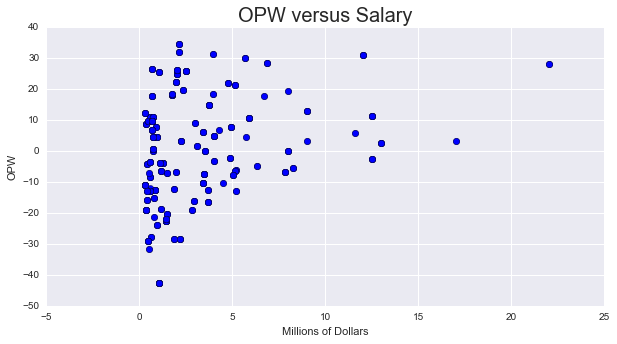

In [39]:
x = playerLS['salary']/float(1e6);
y = playerLS['OPW'];
plt.figure(figsize=(10,5));
plt.scatter(x,y, s = 40);
plt.xlabel('Millions of Dollars');
plt.ylabel('OPW');
plt.title('OPW versus Salary', size = 20);

#### Problem 1(l)
Pick one players from one of each of these 10 position C, 1B, 2B, 3B, SS, LF, CF, RF, DH, or OF keeping the total median salary of all 10 players below 20 million. Report their averaged predicted wins and total salary.

In [63]:
cond1 = playerLS['salary'] <= 5e6
cond2 = playerLS['POS'] != 'P' # can't be a pitcher
playerLS2 = playerLS[cond1 & cond2]
idx = playerLS2.groupby('POS')['OPW'].transform(max) == playerLS2['OPW']
first_DF = playerLS2[idx]
first_DF.index = first_DF.playerID.values
#first_DF.index
new_players = []
keep_index = [0]
for index, player in enumerate(first_DF.index):
    if index == 0:
        new_players.append(player)
    else:
        if player in new_players:
            pass
        else: 
            new_players.append(player)
            keep_index.append(index)
new_players, keep_index
first_DF = first_DF.ix[keep_index]

In [64]:
def removeRepeat(dataframe):
    players = []
    keep = []
    for index, player in enumerate(dataframe.index):
        if player in new_players:
            continue;
        else: 
            #new_players.append(player)
            players.append(player)
            keep.append(index)
    dataframe = dataframe.ix[keep]
    new_players.append(dataframe.head(1).playerID.values[0])
    return dataframe.head(1)

In [65]:
for pos in ['C', 'SS', '2B', '3B', 'LF', 'CF', 'RF', 'DH', 'OF', '1B']:
    if pos in first_DF.POS.values:
        continue;
    cond1 = playerLS['POS'] == pos # can't be a pitcher
    cond2 = playerLS['salary'] <= 3e6
    playerLS2 = playerLS[cond1 & cond2]
    playerLS2.index = playerLS2.playerID.values
    idx = playerLS2.groupby('OPW')['OPW'].transform(max) == playerLS2['OPW']
    new_DF = playerLS2[idx]
    #print new_DF
    output = new_DF[(playerLS2['OPW'] > 17)].sort_values(by ='OPW', ascending=False)[['Career Ended','Career Start','playerID','OPW', '1B','2B', '3B', 'HR', 'BB', 'nameFirst', 'nameLast', 'salary', 'POS']]
    clean_DF = removeRepeat(output)
    #set(clean_DF.index.values).difference()
    first_DF = first_DF.append(clean_DF)
first_DF

,Career Ended,Career Start,playerID,OPW,1B,2B,3B,HR,BB,nameFirst,nameLast,salary,POS
murphda05,1985,1982,murphda05,26.002493,-0.018035,-0.005901,-0.001716,0.022204,0.040026,Dale,Murphy,2000000,C
riceji01,1978,1978,riceji01,34.319894,-0.017988,-0.008648,0.010150,0.031541,0.011413,Jim,Rice,2110000,DH
schmimi01,1974,1974,schmimi01,31.853449,-0.053468,-0.001703,-0.000927,0.035116,0.058889,Mike,Schmidt,2133483,2B
harrato01,1982,1982,harrato01,26.500975,0.003247,-0.000461,-0.000628,0.011205,0.031653,Toby,Harrah,675000,SS
mattido01,1986,1986,mattido01,25.762576,0.015730,0.022247,-0.004526,0.011606,0.007046,Don,Mattingly,2500000,3B
evansdw01,1984,1982,evansdw01,25.397622,-0.026596,0.006486,0.002819,0.013199,0.041319,Dwight,Evans,1070000,LF
gonzalu01,2001,2000,gonzalu01,24.843037,0.000554,0.000579,0.000308,0.018256,0.014978,Luis,Gonzalez,2025000,CF
winfida01,1980,1980,winfida01,22.128933,-0.016215,-0.009256,0.003076,0.006713,0.048924,Dave,Winfield,1958652,RF
murraed02,1984,1984,murraed02,19.644905,0.009709,-0.009165,-0.004315,0.004904,0.039819,Eddie,Murray,2331062,OF
guerrpe01,1989,1989,guerrpe01,17.853143,0.014038,0.015337,-0.007188,-0.003187,0.032576,Pedro,Guerrero,1776666,1B


In [66]:
'Total Money Spent: ', first_DF.salary.sum(), 'Average OPW: ', first_DF.OPW.mean()

('Total Money Spent: ', 18579863, 'Average OPW: ', 25.43070263030759)

These are the cheapest players at each position. Still not perfect code, but pretty good!

#### Problem 1(m)
What do these players outperform in? Singles, doubles, triples HR or BB?

In [46]:
first_DF

,Career Ended,Career Start,playerID,OPW,1B,2B,3B,HR,BB,nameFirst,nameLast,salary,POS
murphda05,1985,1982,murphda05,26.002493,-0.018035,-0.005901,-0.001716,0.022204,0.040026,Dale,Murphy,2000000,C
riceji01,1978,1978,riceji01,34.319894,-0.017988,-0.008648,0.010150,0.031541,0.011413,Jim,Rice,2110000,DH
schmimi01,1974,1974,schmimi01,31.853449,-0.053468,-0.001703,-0.000927,0.035116,0.058889,Mike,Schmidt,2133483,2B
harrato01,1982,1982,harrato01,26.500975,0.003247,-0.000461,-0.000628,0.011205,0.031653,Toby,Harrah,675000,SS
mattido01,1986,1986,mattido01,25.762576,0.015730,0.022247,-0.004526,0.011606,0.007046,Don,Mattingly,2500000,3B
evansdw01,1984,1982,evansdw01,25.397622,-0.026596,0.006486,0.002819,0.013199,0.041319,Dwight,Evans,1070000,LF
gonzalu01,2001,2000,gonzalu01,24.843037,0.000554,0.000579,0.000308,0.018256,0.014978,Luis,Gonzalez,2025000,CF
winfida01,1980,1980,winfida01,22.128933,-0.016215,-0.009256,0.003076,0.006713,0.048924,Dave,Winfield,1958652,RF
murraed02,1984,1984,murraed02,19.644905,0.009709,-0.009165,-0.004315,0.004904,0.039819,Eddie,Murray,2331062,OF
guerrpe01,1989,1989,guerrpe01,17.853143,0.014038,0.015337,-0.007188,-0.003187,0.032576,Pedro,Guerrero,1776666,1B


** Your answer here: ** These players outperform in HR and BB.

### 

### Use one of the classification methods to predict wheather a player will be an Allstar?

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

allstar = pd.read_csv('data/baseball_data/AllstarFull.csv')
allstar = allstar[['playerID','yearID','GP']].drop_duplicates()

#Filter out allstars from players dataset
players_allstar = pd.merge(players,allstar,on=['playerID','yearID'],how ='inner')
players_allstar['GP'] = players_allstar['GP'].fillna(0)


x = players_allstar.drop('GP',axis=1)._get_numeric_data().fillna(0)
y = players_allstar['GP']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train) 
z = pd.DataFrame(zip(rfc.predict(x_test),y_test),columns = ['predicted','actual'])
z['new'] = z['actual']-z['predicted']

print 'Score:','%.2f'%(100 - z[z['new']!=0]['new'].count()*100.0/z['new'].count()),'%'
print rfc.score(x, y)

Score: 88.89 %
0.96992481203


## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---

# Problem 2:  $k$-Nearest Neighbors and Cross Validation 

What is the optimal $k$ for predicting species using $k$-nearest neighbor classification 
on the four features provided by the iris dataset.

In this problem you will get to know the famous iris data set, and use cross validation to select the optimal $k$ for a $k$-nearest neighbor classification. This problem set makes heavy use of the [sklearn](http://scikit-learn.org/stable/) library. In addition to Pandas, it is one of the most useful libraries for data scientists. 
For the Iris data set  sklearn provides an extra function to load it - since it is one of the very commonly used data sets.

In [48]:
from sklearn.datasets import load_iris
iris = load_iris()

#### Problem 2(a) 
Split the data into a train and a test set. Use a random selection of 33% of the samples as test data. Sklearn provides the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function for this purpose. Print the dimensions of all the train and test data sets you have created. 

In [49]:
from sklearn.cross_validation import train_test_split

#Load data and target
X = iris.data
y = iris.target

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)

#### Problem 2(b) 

 Use ***ten fold cross validation*** to estimate the optimal value for $k$ for the iris data set. 

**Note**: For your convenience sklearn does not only include the [KNN classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), but also a [grid search function](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV). The function is called grid search, because if you have to optimize more than one parameter, it is common practice to define a range of possible values for each parameter. An exhaustive search then runs over the complete grid defined by all the possible parameter combinations. This can get very computation heavy, but luckily our KNN classifier only requires tuning of a single parameter for this problem set. 

In [50]:
knn = sklearn.neighbors.KNeighborsClassifier()
grid_search = sklearn.grid_search.GridSearchCV(knn, {'n_neighbors':list(range(1,20))}, cv=10)
grid_search.fit(X_train, y_train)
k = grid_search.best_params_['n_neighbors']
print 'k =',grid_search.best_params_['n_neighbors']

k = 15


#### Problem 2(c)

Visualize the result by plotting the score results versus values for $k$. 

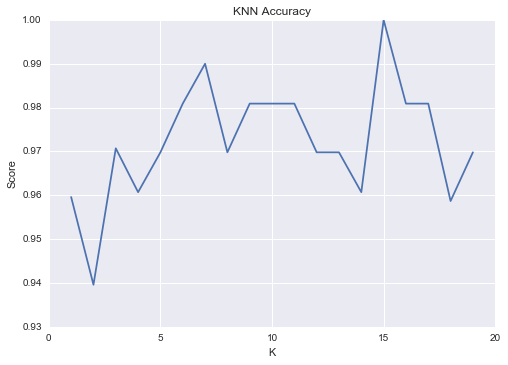

In [51]:
scores = []

for i in range(1,20):
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=i)
    score = np.mean(sklearn.cross_validation.cross_val_score(clf, X_train, y_train, cv=10))
    scores.append(score)

plt.plot(list(range(1,20)), scores)
plt.xlabel('K')
plt.ylabel('Score')
plt.title('KNN Accuracy')

Verify that the grid search has indeed chosen the right parameter value for $k$.

In [52]:

print 'Based on the plot, grid search produced the optimal k value.'

Based on the plot, grid search produced the optimal k value.


#### Problem 2(d)

Test the performance of our tuned KNN classifier on the test set.

In [53]:
### Your code here ###

#Take the average score of 10 runs
scores = []
for i in range(10):
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = float(np.sum([i==j for i,j in zip(pred, y_test)]))/len(pred)
    scores.append(score)
    
print 'Score:\t',np.mean(scores)*100,'%'

Score:	94.0 %


## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---

## Problem 3: Supervised Learning - Estimating Automobile Pricing using Linear Regression and Regression Trees

Download the UCI ML automobile dataset. (https://archive.ics.uci.edu/ml/datasets/Automobile)

In [74]:
header = ['symboling','normalized-losses','make','fuel-type','aspiration',
          'num-of-doors', 'body-style','drive-wheels','engine-location',
          'wheel-base','length','width','height','curb-weight','engine-type',
          'num-of-cylinders','engine-size','fuel-system','bore','stroke',
          'compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg',
          'price']

auto = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data', names=header)
auto.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Get UCI ML automobile dataset and Information about the Data

#### Find the most important features

In [75]:
### Your code here ###


#Replace '?' with NaN
auto = auto.replace(to_replace='?', value=np.nan)

#Convert relevant numeric data from object to float
change_num = ['bore','stroke','horsepower','peak-rpm','price']
auto[change_num]=auto[change_num].astype(float, inplace=True)

#Select columns with numbers
num_auto = auto._get_numeric_data().dropna()
num_auto.head()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [76]:


#Taking features that has an abolute correlation of 0.5+ against price
feature_list = num_auto.columns[0:-1]
price = num_auto['price']

for feature in feature_list:
    attr = num_auto[feature]
    c = corr(attr,price)
    if np.sqrt(c**2) > 0.7:
        print feature,':\t\t%.2f'%c



width :		0.76
curb-weight :		0.84
engine-size :		0.89
horsepower :		0.82
city-mpg :		-0.71
highway-mpg :		-0.72


#### Using 10-fold cross validation separate the test and training data sets

In [77]:
#Attributes with highest correlation
attr = ['width', 'curb-weight', 'engine-size', 'horsepower', 'highway-mpg','price','city-mpg']

#Picking important features
new_auto = auto[attr].dropna()
X = new_auto[new_auto.columns - ['price']]
y = new_auto['price']

k_fold = sklearn.cross_validation.KFold(len(X), n_folds=10, shuffle=True, random_state=44)

/Users/mgalarny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


Normalize the data

In [78]:
X = (X - X.mean()) / (X.max() - X.min())
X.head()

,city-mpg,curb-weight,engine-size,highway-mpg,horsepower,width
0,-0.116695,-0.003115,0.011984,-0.096932,0.035528,-0.152343
1,-0.116695,-0.003115,0.011984,-0.096932,0.035528,-0.152343
2,-0.172250,0.103557,0.095003,-0.123248,0.236463,-0.032685
3,-0.033361,-0.084961,-0.067261,-0.017985,-0.006528,0.027144
4,-0.200028,0.103945,0.034626,-0.228511,0.054220,0.044238


### Start with a linear model and evaluate how well it can predict the price variable

In [79]:
scores = [] 

for train_index, test_index in k_fold:
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    lm = sklearn.linear_model.LinearRegression()
    lm.fit(X_train, y_train)
    scores.append(lm.score(X_test, y_test))
    
print 'Score:\t', '%.2f'%(np.mean(scores)*100),'%'

Score:	73.10 %


### Try using Ridge regression and evaluate the result of the 10-fold cross-validation

In [80]:
scores = [] 

for train_index, test_index in k_fold:
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    rm = sklearn.linear_model.Ridge()
    rm.fit(X_train, y_train)
    predict = rm.predict(X_test)
    score = float(np.sum([i==j for i,j in zip(predict,y_test)])/len(y_test))
    scores.append(rm.score(X_test, y_test))
    
print 'Score:\t', '%.2f'%(np.mean(scores)*100),'%'

Score:	73.82 %


### Train the Regression Tree and evaluate using 10-fold cross validation; Specify the parameters used and how you changed them to increase the accuracy;  

In [81]:
dtr = sklearn.tree.DecisionTreeRegressor()
grid_search = sklearn.grid_search.GridSearchCV(dtr, 
                                               {'min_samples_split':list(range(1,10)), 
                                                'min_samples_leaf':list(range(1,10)), 
                                                'min_weight_fraction_leaf':np.linspace(0,0.5,10)}, 
                                               cv=10)
grid_search.fit(X_train, y_train)
print 'Best Parameters:'
grid_search.best_params_

Best Parameters:


{'min_samples_leaf': 9,
 'min_samples_split': 1,
 'min_weight_fraction_leaf': 0.0}

In [82]:
score = grid_search.score(X_test, y_test)

print 'Score:\t','%.2f'%(score*100),'%'

Score:	87.07 %


### Discussion for Problem 3  Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.Compare all three aproaches and discuss your findings in 100 words or less